In [2]:
import argparse
import os
import torch

import numpy as np
import cv2
import glob
from torch import nn

import segmentation_models_pytorch as smp
from loguru import logger
import rioxarray as xr

import xarray as xar

import natsort
import warnings
warnings.filterwarnings("ignore")


def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def image_preprocessing(image_path):

    xr_image = xr.open_rasterio(image_path, masked=False).values
    red = xr_image[3,:,:]
    green = xr_image[2,:,:]
    blue = xr_image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    return rgb_composite_n

def load_model(model_path, device):
    """
    Load the trained model from the given path.

    Args:
        model_path (str): Path of the trained model.

    Returns:
        model (nn.Module): The loaded model.

    """
    model = smp.Unet(encoder_name="resnet18", encoder_weights=None,in_channels=3, classes=1, activation='sigmoid')

    if device.type == 'cpu':
        checkpoint = torch.load(model_path, map_location=device)
        new_state_dict = OrderedDict()
        for k, v in checkpoint.items():
            name = k[7:] #remove 'module'
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        logger.info(model.eval())

    else:
        
        logger.info("==> Loading checkpoint '{}'".format(model_path))
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()
        model.cuda()
    
    return model


In [9]:
model_path = "/home/sebastien/Documents/projects/solafune-solar-panel-detection/results/2023_10_08_22_50_46/best.pth"
hardware = "cuda"

if hardware=='cuda':
    device = torch.device(hardware)
    model = load_model(model_path, device)
    model.to(hardware)
    if len(str(hardware))>1:
        model= nn.DataParallel(model)
    print("------")
    print("Model run on: {}".format(hardware))
    print("------")

else:
    device = torch.device(hardware)
    model = load_model(model_path, device)
    model.to(hardware)
    print("------")
    print("Model run on: {}".format(hardware))
    print("------")

prediction_dir = "inference_test"
if not os.path.exists("inference_test"):
    print("Create prediction directory...")
    os.makedirs(prediction_dir, exist_ok=True)
# Read input
input = "/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/evaluation"

images_path = natsort.natsorted(glob.glob(os.path.join(input, "*.tif"), recursive=False))

eval_masks = natsort.natsorted(glob.glob(os.path.join("/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/sample", "*.tif"), recursive=False))

output = "/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/submit"


2023-10-09 02:16:34.493 | INFO     | __main__:load_model:63 - ==> Loading checkpoint '/home/sebastien/Documents/projects/solafune-solar-panel-detection/results/2023_10_08_22_50_46/best.pth'


------
Model run on: cuda
------


In [11]:
for i in range(len(images_path)):

    path_image = images_path[i]
    image = image_preprocessing(path_image)
    h, w, _ = image.shape
    image = cv2.resize(image, (32, 32),interpolation=cv2.INTER_NEAREST)/255.0
    image = np.transpose(image, (2,1,0))
    image = torch.Tensor(image)        
    image = torch.unsqueeze(image,dim=0)
    
    with torch.no_grad():
    
        mask_pred = model(image)
    
    mask_pred = mask_pred.detach().cpu().numpy()

    mask_pred = mask_pred[0,:,:,:]
    
    binary_predictions = (mask_pred > 0.5).astype(np.uint8)
    binary_predictions = binary_predictions[0,:,:]
    pred_rgb = np.zeros((binary_predictions.shape[0], binary_predictions.shape[1], 3), dtype=np.uint8)
    pred_rgb[..., 0] = binary_predictions * 255  
    pred_rgb[..., 1] = binary_predictions * 255  
    pred_rgb[..., 2] = binary_predictions * 255
    pred_rgb = cv2.resize(pred_rgb,(w,h),interpolation=cv2.INTER_NEAREST)

    binary_predictions = torch.Tensor(pred_rgb[:,:,0])/255.0
    binary_predictions = binary_predictions.to(torch.int)
    binary_predictions = torch.unsqueeze(binary_predictions,dim=0)
    binary_predictions = binary_predictions.detach().cpu().numpy()


    # logger.info("binary_predictions +> {}".format(binary_predictions.shape))
    eval_masks_path = eval_masks[0]
    mask_sample = xr.open_rasterio(eval_masks_path, mask=True)
    # logger.info("mask_sample +> {}".format(mask_sample.shape))

    x = mask_sample['x'].values
    y = mask_sample['y'].values
    band = mask_sample['band'].values

    final = xar.DataArray(binary_predictions, dims=('band','y', 'x'), coords={'band': band,'y': np.arange(0.5,binary_predictions.shape[1],1), 'x': np.arange(0.5,binary_predictions.shape[2])})
    logger.info("final +> {}".format(final.shape))

    head, tail = os.path.split(path_image)

    filename_submit = os.path.join(output,tail.replace("image","mask"))
    final.rio.to_raster(filename_submit)

2023-10-09 02:17:31.486 | INFO     | __main__:<module>:43 - final +> (1, 24, 23)
2023-10-09 02:17:31.506 | INFO     | __main__:<module>:43 - final +> (1, 24, 23)
2023-10-09 02:17:31.523 | INFO     | __main__:<module>:43 - final +> (1, 23, 24)
2023-10-09 02:17:31.537 | INFO     | __main__:<module>:43 - final +> (1, 23, 23)
2023-10-09 02:17:31.548 | INFO     | __main__:<module>:43 - final +> (1, 23, 23)
2023-10-09 02:17:31.559 | INFO     | __main__:<module>:43 - final +> (1, 23, 23)
2023-10-09 02:17:31.569 | INFO     | __main__:<module>:43 - final +> (1, 23, 23)
2023-10-09 02:17:31.581 | INFO     | __main__:<module>:43 - final +> (1, 24, 23)
2023-10-09 02:17:31.592 | INFO     | __main__:<module>:43 - final +> (1, 23, 23)
2023-10-09 02:17:31.603 | INFO     | __main__:<module>:43 - final +> (1, 25, 25)
2023-10-09 02:17:31.614 | INFO     | __main__:<module>:43 - final +> (1, 24, 23)
2023-10-09 02:17:31.626 | INFO     | __main__:<module>:43 - final +> (1, 23, 22)
2023-10-09 02:17:31.636 | IN

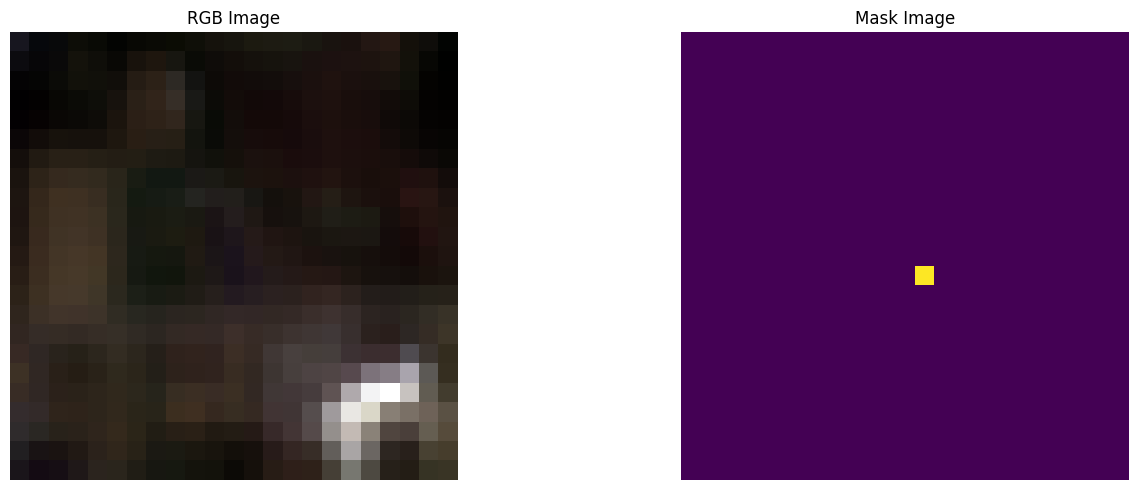

In [9]:
import rioxarray as rxr
import matplotlib.pyplot as plt


image_path =  "/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/evaluation/evaluation_s2_image_606.tif"
image = rxr.open_rasterio(image_path, masked=False).values

mask = rxr.open_rasterio("/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/submit/evaluation_s2_mask_606.tif", masked=True).values
mask = mask[0,:,:]

red = image[3,:,:]
green = image[2,:,:]
blue = image[1,:,:]

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)
rgb_composite_n= np.dstack((red_n, green_n, blue_n))

# print("image path {}".format(image_path))
# print("image {}".format(rgb_composite_n.shape))
# print("mask path {}".format(mask_path))
# print("mask {}".format(mask.shape))


# Create a figure with subplots to display the images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display the images
axes[0].imshow(rgb_composite_n)
axes[0].set_title('RGB Image')
axes[0].axis('off')


axes[1].imshow(mask)
axes[1].set_title('Mask Image')
axes[1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()